# PPCA in TensorFlow Probability
This is the PPCA method applied in TensorFlow Probability (TFP) on a small set of generated data. The code is based on one of TensorFlow's tutorials of TFP. The tutorial has been extended from an $x = Wz$ model to an $x = Wz + \mu$ model. We will start with the code as given in the tutorial.

First we import necessary libraries

In [98]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

We create a function of the original $x = Wz$ model:

In [99]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=stddv_datapoints,
      name="x"), reinterpreted_batch_ndims=2)

In [100]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)


And we generate some data:

Principal axes:
tf.Tensor(
[[1.5381562]
 [1.1806691]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-0.77150655  0.8316258  -0.53472406 ...  1.6293368   1.6051625
   1.0891726 ]], shape=(1, 5000), dtype=float32)


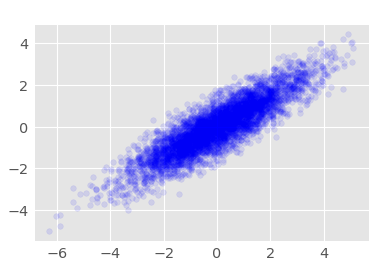

In [101]:
actual_w, actual_z, x_train = model_basis.sample()

print("Principal axes:")
print(actual_w)
print(actual_z)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
# plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

The error is mimized numerically:

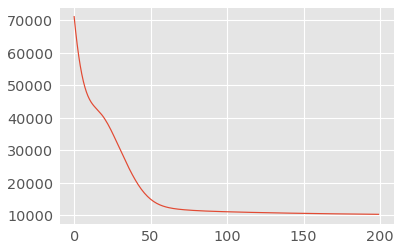

In [102]:
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda w, z: model_basis.log_prob((w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()

And we end up with a model that predicts the $x$ values acurately, based on our guesses of $z$ and $W$.

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[2.5125072],
       [1.9187683]], dtype=float32)>


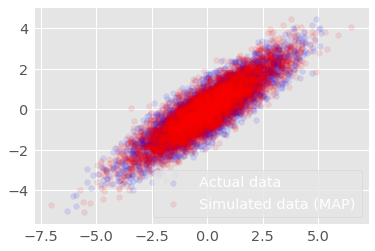

In [103]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model_basis.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
# plt.axis([-20, 20, -20, 20])
plt.show()

## Addition of $\mu$ variable to the model:
Because we want to model the relation between our latent and observed data fundamentally different, we have to create a new model. Also, we wish to compare both models, with the same sets of data. For this reason, we create one function that outputs $x$ variables as generated by the original $x=Wz$-model and the $x=Wz+\mu$-model. We create the model and generate random data similarly as done before:

In [104]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_multi(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=5.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_original = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints,
        name="x_original"), reinterpreted_batch_ndims=2)
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    
concrete_ppca_model_multi = functools.partial(probabilistic_pca_multi,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_multi = tfd.JointDistributionCoroutine(concrete_ppca_model_multi)

In [73]:
actual_w, actual_z, actual_mu, x_orig_train, x_mu_train = model_multi.sample()

print("Principal axes:")
print(actual_w)
print(actual_z)

Principal axes:
tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)


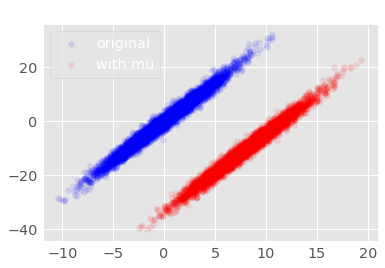

In [74]:
plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='original')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='red', alpha=0.1,label='with mu')
# plt.axis([-20, 20, -20, 20])
plt.legend()
plt.title("Data set")
plt.show()

The scatter plot shows how the data is very much alike, except for the relocation of the mean of $x$ in both dimensions (which is the addition of a non-zero $\mu$). Shortly after generating this data, it became apparaent that to mimize the error according to both models (the original- and the $\mu$-model), we need separate functions for both. The original function was created already in the example above, so we create another additional function for our $\mu$ model.

In [105]:
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=5.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    

concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

Now we optimize the values of $z$ and $W$ for both models, and $\mu$ for the later model. The results are plotted below.

In [106]:
w_orig = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_orig = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn_basis = lambda w_orig, z_orig: model_basis.log_prob((w_orig, z_orig, x_orig_train))
losses_basis = tfp.math.minimize(lambda: -target_log_prob_fn_basis(w_orig, z_orig),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.Variable(np.ones([data_dim,1]), dtype=tf.float32)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

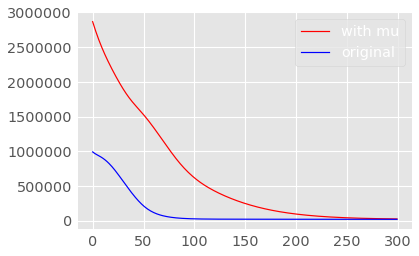

In [77]:
plt.plot(losses_mu[:,0], label='with mu', color='red')
plt.plot(losses_basis, label='original', color='blue')
plt.legend()
plt.show()

Original model:
MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.695059],
       [4.967769]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dtype=float32, numpy=
array([[-1.3063012 ,  1.94281   , -0.7569958 , ...,  2.6152823 ,
         3.5658562 ,  0.25145918]], dtype=float32)>

MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-1.2643054],
       [-4.500533 ]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) 

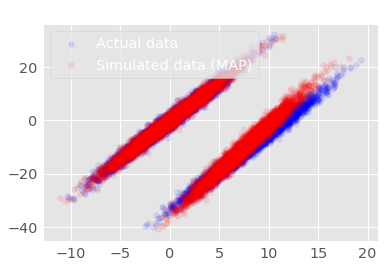

In [78]:
print('Original model:')
print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_orig)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_orig)
print()

_, _, x_generated_orig = model_basis.sample(value=(w_orig, z_orig, None))

plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_orig[0, :], x_generated_orig[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
# plt.legend()
# plt.title('Original model')
# plt.axis([-20, 20, -20, 20])
# plt.show()

print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_mu)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_mu)
print()
print('actual mu: ',actual_mu)
print('Estimated mu: ',mu_mu)

_, _, _, x_generated_mu = model_mu.sample(value=(w_mu, z_mu, mu_mu, None))
plt.legend()
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')

plt.title('Model with and without mu')
# plt.axis([-20, 20, -20, 20])
plt.show()

The original model (which has data centered around zero) works as before. Clearly noticable is that the new $\mu$-model predicts the data 'somewhat' accurately, but the covariance between dimensions looks unmatching with the original data. On first sight, one might conclude that $\mu$ was predicted correctly but $W$ or $z$ was not. Upon further inspection however, we see that $\mu$ is not predicted correctly at all! The mean position of our data is recreated by adjusting the $W$ matrix, which results in our data taking an elliptical form 'pointing' to the origin of our plot. For this reason, it might be better to predict $\mu$ first, before trying to guess $W$ or $z$. This was done by optimizing another model which <i>only</i> contained $\mu$ (i.e. $x = \mu$).

Edit: The error described above is not always apparent, but it definitely arises sometimes!

In [107]:
def probabilistic_pca_onlymu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=4.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
concrete_ppca_model_onlymu = functools.partial(probabilistic_pca_onlymu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_onlymu = tfd.JointDistributionCoroutine(concrete_ppca_model_onlymu)

This time we optimize $\mu$ first, and then the complete $\mu$-model:

In [108]:
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.Variable(np.ones([data_dim,1]), dtype=tf.float32)

target_log_prob_fn_onlymu = lambda mu_mu: model_onlymu.log_prob((mu_mu, x_mu_train))
losses_onlymu = tfp.math.minimize(lambda: -target_log_prob_fn_onlymu(mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

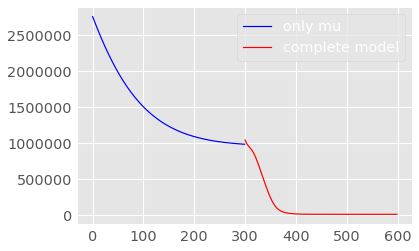

In [85]:
plt.plot(losses_onlymu[:,0], label='only mu', color='blue')
plt.plot(range(300,600), losses_mu[:,0], label='complete model', color='red')
plt.legend()
plt.show()

As we can see, most of the error is reduced by optimizing $\mu$, while the complete model only resolves the last bits of error. The final results of our model are plotted below. This time, our predicted data fits the original data.

Original model:
MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.695059],
       [4.967769]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dtype=float32, numpy=
array([[-1.3063012 ,  1.94281   , -0.7569958 , ...,  2.6152823 ,
         3.5658562 ,  0.25145918]], dtype=float32)>

MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.4665427],
       [4.3114758]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dt

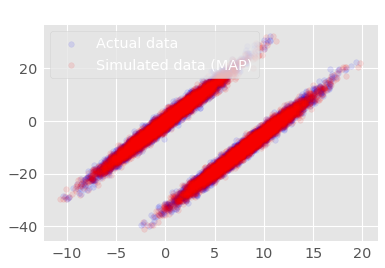

In [86]:
print('Original model:')
print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_orig)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_orig)
print()

_, _, x_generated_orig = model_basis.sample(value=(w_orig, z_orig, None))

plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_orig[0, :], x_generated_orig[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
# plt.legend()
# plt.title('Original model')
# plt.axis([-20, 20, -20, 20])
# plt.show()

print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_mu)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_mu)
print()
print('actual mu: ',actual_mu)
print('Estimated mu: ',mu_mu)

_, _, _, x_generated_mu = model_mu.sample(value=(w_mu, z_mu, mu_mu, None))
plt.legend()
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')

plt.title('Model with and without mu')
# plt.axis([-20, 20, -20, 20])
plt.show()

Instead of building a model to optimize $\mu$, we could of course also just use the analytical solution ($\mu = \frac{1}{N} \sum^N_{n=1}x_n$), which is quicker and more accurate:

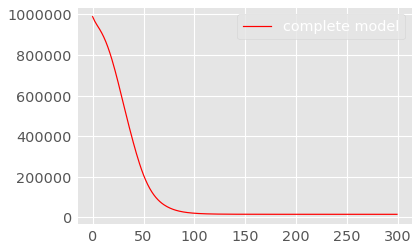

In [87]:
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.expand_dims(tf.reduce_mean(x_mu_train, 1),1)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)
plt.plot(losses_mu[:,0], label='complete model', color='red')
plt.legend()
plt.show()

Original model:
MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.695059],
       [4.967769]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dtype=float32, numpy=
array([[-1.3063012 ,  1.94281   , -0.7569958 , ...,  2.6152823 ,
         3.5658562 ,  0.25145918]], dtype=float32)>

MAP-estimated axes:
actual W:  tf.Tensor(
[[1.582751 ]
 [4.6527247]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.5608135],
       [4.5893955]], dtype=float32)>

actual Z:  tf.Tensor(
[[-1.4149268   2.1053886  -0.80042714 ...  2.7960167   4.04597
   0.3241136 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dt

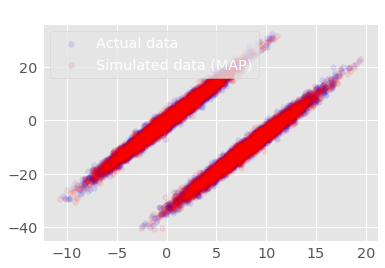

In [88]:
print('Original model:')
print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_orig)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_orig)
print()

_, _, x_generated_orig = model_basis.sample(value=(w_orig, z_orig, None))

plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_orig[0, :], x_generated_orig[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
# plt.legend()
# plt.title('Original model')
# plt.axis([-20, 20, -20, 20])
# plt.show()

print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_mu)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_mu)
print()
print('actual mu: ',actual_mu)
print('Estimated mu: ',mu_mu)

_, _, _, x_generated_mu = model_mu.sample(value=(w_mu, z_mu, mu_mu, None))
plt.legend()
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')

plt.title('Model with and without mu')
# plt.axis([-20, 20, -20, 20])
plt.show()

And we end up with the same result!

# Variational inference with $\mu$ (not working yet)

In [109]:
qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qmu_mean = tf.Variable(np.ones([data_dim, 1]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))
qmu_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, 1]), dtype=tf.float32))

def factored_normal_variational_model():
    qw = yield Root(tfd.Independent(tfd.Normal(
        loc=qw_mean, scale=qw_stddv, name="qw"), reinterpreted_batch_ndims=2))
    qz = yield Root(tfd.Independent(tfd.Normal(
        loc=qz_mean, scale=qz_stddv, name="qz"), reinterpreted_batch_ndims=2))
    qmu = yield Root(tfd.Independent(tfd.Normal(
        loc=qmu_mean, scale=qmu_stddv, name="qmu"), reinterpreted_batch_ndims=1))

surrogate_posterior = tfd.JointDistributionCoroutine(
    factored_normal_variational_model)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn_mu,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.58703446],
       [-4.4969597 ]], dtype=float32)>
Standard Deviation:
tf.Tensor(
[[0.01814996]
 [0.01814996]], shape=(2, 1), dtype=float32)


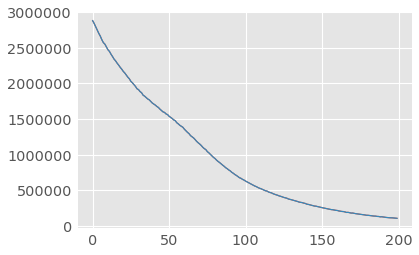

In [110]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

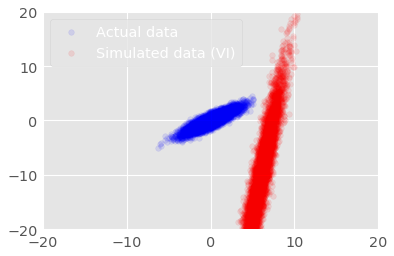

In [111]:
posterior_samples = surrogate_posterior.sample(50)
_, _, _, x_generated = model_mu.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()